In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torchvision.io import read_image
from torch.utils import data
from torch.utils.data import random_split,DataLoader
import string
from PIL import Image
import matplotlib.pyplot as plt
import time
import shutil
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from torch.nn.parallel import DataParallel

In [53]:
USE_CUDA = torch.cuda.is_available()

print("Device : {0}".format("GPU" if USE_CUDA else "CPU"))
device = torch.device("cuda" if USE_CUDA else "cpu")
cpu_device = torch.device("cpu")

BATCH_SIZE=128
VAL_SPLIT=0.2

AFFN_KERNEL=5
AFFN_STRIDE=1
AFFN_DEPTH=2

CRNN_KERNEL=5
CRNN_POOL_KERNEL=2
CRNN_DROPOUT=0.3
CRNN_LATENT=128
LSTM_HIDDEN_DIM=32
VOCAB_SIZE=26+10
OUTPUT_LENGTH=6

SAVE_EPOCH=10
VAL_EPOCH=1
EPOCHS= 70
epoch_count = [i for i in range(1,EPOCHS+1)]

train_acc=[]
test_acc=[]

Device : GPU


In [7]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("CUDA is available. Using GPU(s):", torch.cuda.device_count())
else:
    device = torch.device('cpu')
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU(s): 1


In [9]:
data = '/kaggle/input/captchaimgdata/trainset'

In [54]:
import os
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, Dataset
from PIL import Image
import string
import zipfile

def get_dataloaders(data_dir, batch_size=32, val_split=0.2, shuffle=True, num_workers=0):
    # Define the character set (vocabulary)
    characters = string.ascii_uppercase + string.digits  # Uppercase + lowercase + digits
    char_to_idx = {char: idx for idx, char in enumerate(characters)}
    vocab_size = len(characters)

    class CustomDataset(Dataset):
        def __init__(self, root_dir, transform=None):
            self.root_dir = root_dir
            self.transform = transform
            self.image_paths = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith(('png', 'jpg', 'jpeg'))]
            self.labels = [os.path.basename(f).split('.')[0].upper() for f in self.image_paths]  # Extract filename as label

        def __len__(self):
            return len(self.image_paths)

        def __getitem__(self, idx):
            img_path = self.image_paths[idx]
            image = Image.open(img_path).convert('RGB')
            label_str = self.labels[idx]

            # Convert label string to one-hot encoded tensor
            label_indices = [char_to_idx[c] for c in label_str if c in char_to_idx]  # Map characters to indices
            label_tensor = torch.zeros(len(label_indices),dtype=torch.long)  # One-hot encoding tensor
            for i, index in enumerate(label_indices):
                label_tensor[i] = index  # Set one-hot encoding

            if self.transform:
                image = self.transform(image)

            return image, label_tensor

    transform = transforms.Compose([
        transforms.Resize((64,192)),  # Resize to a fixed size
        transforms.ToTensor(),
        transforms.Grayscale(),
        transforms.Lambda(lambda x: x / 255),
    ])

    dataset = CustomDataset(root_dir=data_dir, transform=transform)
    print(f"Dataset size: {len(dataset)}")  # Print dataset size

    # Compute train-validation split
    total_size = len(dataset)
    val_size = int(total_size * val_split)
    train_size = total_size - val_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader


In [11]:
train_loader,val_loader=get_dataloaders(data_dir= data, batch_size=BATCH_SIZE, val_split=0.2, shuffle=True)

Dataset size: 26155


In [55]:
train_features_batch, train_labels_batch = next(iter(train_loader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([128, 1, 64, 192]), torch.Size([128, 6]))

In [13]:
#def accuracy_fn(y_true, y_pred):
        #correct = torch.eq(y_true, y_pred).sum().item()
        #acc = (correct / len(y_true))
        #return acc
def accuracy_fn(y_true, y_pred):
            y_true = y_true.cpu()  
            y_pred = y_pred.cpu()

            y_true = y_true.view(-1)  
            y_pred = y_pred.view(-1)  

            correct = torch.eq(y_true, y_pred).sum().item()
            total_samples = len(y_true) 

            acc = (correct / total_samples)*100
            return acc

In [56]:
class Encoder(nn.Sequential):
    def __init__(self,n,kernel_size,stride):
        super().__init__(
            nn.Conv2d(in_channels=4**(n-1),out_channels=4**n,kernel_size=kernel_size,stride=stride),
            nn.BatchNorm2d(num_features=4**n),
            nn.ReLU(inplace=False)
        )
class Decoder(nn.Sequential):
    def __init__(self,n,kernel_size,stride):
        super().__init__(
            nn.ConvTranspose2d(in_channels=4**n,out_channels=4**(n-1),kernel_size=kernel_size,stride=stride),
            nn.BatchNorm2d(num_features=4**(n-1)),
            nn.ReLU(inplace=False)
        )

In [57]:
class AFFN(nn.Module):
    def __init__(self,n):
        super().__init__()
        self.n=n
        self.alpha=nn.Parameter(torch.randn(n-1).to(device)).to(device)

        #During training, the values of alpha are adjusted by the optimizer to learn the optimal feature fusion strategy. If alpha[i] is close to 0,
        #the network emphasizes the direct path.
        #If alpha[i] is close to 1, it emphasizes the residual path.
        self.encoders=[]
        for i in range(1,n+1):
            self.encoders.append(Encoder(i,AFFN_KERNEL,AFFN_STRIDE).to(device))

        self.decoders=[]
        for i in range(n,0,-1):
            self.decoders.append(Decoder(i,AFFN_KERNEL,AFFN_STRIDE).to(device))

    def forward(self, x):
        residuals = []
        for i, enc in enumerate(self.encoders):
            x = enc(x)
            if i < self.n - 1:
                x = x * (1 - self.alpha[i])
                residuals.append(x * self.alpha[i])

        for i, dec in enumerate(self.decoders):
            x = dec(x)
            if i < self.n - 1:
                x = x + residuals.pop()

        return x

In [58]:
class CRNN(nn.Module):
    def __init__(self, in_channels, kernel_size, pool_kernel_size, dropout, latent_dim, lstm_hidden_dim, vocab_size, output_length=5):
        super().__init__()
        self.lstm_hidden_dim = lstm_hidden_dim
        self.output_length = output_length  
        self.vocab_size = vocab_size

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=in_channels*2, kernel_size=kernel_size, padding=2),
            nn.BatchNorm2d(num_features=in_channels*2),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=pool_kernel_size)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels*2, out_channels=in_channels*4, kernel_size=kernel_size, padding=2),
            nn.BatchNorm2d(num_features=in_channels*4),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=pool_kernel_size)
        )
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout)
        self.latent_fc = nn.LazyLinear(latent_dim)
        self.lstm = nn.LSTM(input_size=latent_dim, hidden_size=lstm_hidden_dim, num_layers=1, batch_first=True)
        self.output_fc = nn.Linear(lstm_hidden_dim, vocab_size)

    def forward(self, x):
        batch_size = x.size(0)

        conv1_out = self.conv1(x)
        conv2_out = self.conv2(conv1_out)
        flattened = self.flatten(conv2_out)
        dropped = self.dropout(flattened)
        latent = self.latent_fc(dropped)

        lstm_input = latent.unsqueeze(1)

        h0 = torch.zeros(1, batch_size, self.lstm_hidden_dim).to(x.device)
        c0 = torch.zeros(1, batch_size, self.lstm_hidden_dim).to(x.device)

        outputs = []

        for _ in range(self.output_length):
            out, (h0, c0) = self.lstm(lstm_input, (h0, c0))  # out shape: (batch_size, 1, lstm_hidden_dim)

            logits = self.output_fc(out.squeeze(1))  # Shape: (batch_size, vocab_size)

            outputs.append(logits)

        outputs = torch.stack(outputs, dim=1)  # Shape: (batch_size, 6, vocab_size)

        return outputs


In [59]:
class CaptchaCrackNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.affn=AFFN(AFFN_DEPTH).to(device)

        self.conv1=nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=32,kernel_size=5,padding=2),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=2)
        ).to(device)

        self.conv2=nn.Sequential(
                    nn.Conv2d(in_channels=32,out_channels=48,kernel_size=5,padding=2),
                    nn.ReLU(inplace=False),
                    nn.MaxPool2d(kernel_size=2)
                ).to(device)

        self.conv3=nn.Sequential(
            nn.Conv2d(in_channels=48,out_channels=64,kernel_size=5,padding=2),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=2)
        ).to(device)

        self.res=nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=2, padding=2).to(device)

        self.crnn=CRNN(64,CRNN_KERNEL,CRNN_POOL_KERNEL,CRNN_DROPOUT,CRNN_LATENT,LSTM_HIDDEN_DIM,VOCAB_SIZE,OUTPUT_LENGTH).to(device)

    def forward(self,x):
        affn_out=self.affn(x)
        res_out=self.res(x)
        conv1_out=self.conv1(affn_out)
        conv2_out=self.conv2(conv1_out+res_out)
        conv3_out=self.conv3(conv2_out)
        output=self.crnn(conv3_out)
        return output


In [60]:
def train(model,train_loader,val_loader,epochs=EPOCHS):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.0005)
    model.to(device)
    train_history=[]
    val_history=[]
    train_acc=[]
    val_acc=[]
    for epoch in range(1,epochs+1):
        print(f"Epoch {epoch}:")
        avg_acc=0
        avg_loss=0
        model.train()
        for batch_num,(X,y) in enumerate(tqdm(train_loader,desc="Progress: ")):

            X=X.to(device)
            y=y.to(device)
            optimizer.zero_grad()
            preds=model(X).to(device)

            loss=loss_fn(preds.view(-1, VOCAB_SIZE),y.view(-1))
            loss.backward()
            optimizer.step()

            avg_loss+=loss.item()
            avg_acc+=accuracy_fn(y_true=y.cpu(),y_pred=torch.argmax(preds,dim=2).cpu())


        avg_loss/=len(train_loader)
        avg_acc/=len(train_loader)
        train_acc.append(avg_acc)
        print(f"Train Acc: {avg_acc}%")
        train_history.append(avg_loss)
        print(f"Train Loss: {avg_loss}")

        eval_loss=0
        eval_acc=0
        if VAL_EPOCH and epoch%VAL_EPOCH==0:
            model.eval()
            with torch.no_grad():
                for batch_num,(X,y) in enumerate(tqdm(val_loader,desc="Progress: ")):
                    X=X.to(device)
                    y=y.to(device)
                    preds=model(X).to(device)
                    loss=loss_fn(preds.view(-1, VOCAB_SIZE),y.view(-1))
                    eval_acc+=accuracy_fn(y_true=y,y_pred=torch.argmax(preds,dim=2))
                    eval_loss+=loss.item()
                eval_acc/=len(val_loader)
                val_acc.append(eval_acc)
                print(f"Val Acc: {eval_acc}%")
                eval_loss/=len(val_loader)
                val_history.append(eval_loss)
                print(f"Val Loss: {eval_loss}")


        if SAVE_EPOCH and epoch%SAVE_EPOCH==0:
            print("Saving model")
            path=str(epoch)+'.pth'
            torch.save(model.state_dict(), path)
    torch.save(model.state_dict(),'final.pth')

    return train_history,val_history,train_acc,val_acc




In [61]:
model=CaptchaCrackNet().to(device)

In [ ]:
# 1. Instantiate the model
loaded_model = CaptchaCrackNet() 

# 2. Load the state dictionary
#Replace 'final.pth' or '10.pth' with your actual saved file name
state_dict = torch.load('final.pth', map_location=torch.device('cpu')) # you may need map_location=torch.device('cpu')

# 3. Load the state dictionary into the model
loaded_model.load_state_dict(state_dict) 

# Set the model to evaluation mode
loaded_model.eval()

In [63]:
train_history,val_history,train_acc,val_acc =train(model,train_loader,val_loader,EPOCHS)

Epoch 1:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 28.36461509146342%
Train Loss: 2.4392215464173295


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 28.737531357577087%
Val Loss: 2.416348486411862
Epoch 2:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 30.015349762872624%
Train Loss: 2.3393047190294034


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 31.445984856808025%
Val Loss: 2.2843646712419465
Epoch 3:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 32.51487339092138%
Train Loss: 2.232546285885136


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 34.604631308137414%
Val Loss: 2.161041050422482
Epoch 4:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 35.6861344004065%
Train Loss: 2.1148370795133635


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 37.01209784479603%
Val Loss: 2.04604712346705
Epoch 5:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 38.39970782520324%
Train Loss: 2.0036132546459755


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 40.10651276276277%
Val Loss: 1.9447491517881068
Epoch 6:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 41.11296366869919%
Train Loss: 1.8926236229698832


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 42.643701246978694%
Val Loss: 1.820501792721632
Epoch 7:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 43.65255547086721%
Train Loss: 1.7864042854890592


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 44.86794340071779%
Val Loss: 1.7477851873490868
Epoch 8:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 45.83788533197832%
Train Loss: 1.6939083148793477


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 47.09026862228081%
Val Loss: 1.632764351077196
Epoch 9:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 47.75528243563684%
Train Loss: 1.6073152844498797


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 48.76169042518128%
Val Loss: 1.5552556165834752
Epoch 10:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 49.35811526084011%
Train Loss: 1.5342486936871598


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 49.54562985241339%
Val Loss: 1.498234501699122
Saving model
Epoch 11:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 50.83333333333334%
Train Loss: 1.4681357007201126


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 52.16513197648868%
Val Loss: 1.413986235130124
Epoch 12:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 52.35026041666666%
Train Loss: 1.404412114765586


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 53.140821843184646%
Val Loss: 1.3543102566788836
Epoch 13:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 53.813833841463406%
Train Loss: 1.3409305302108205


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 55.054606817183036%
Val Loss: 1.2962527740292433
Epoch 14:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 55.482988228319776%
Train Loss: 1.2852855535542094


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 56.77269304365342%
Val Loss: 1.2428718572709618
Epoch 15:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 57.21004827235772%
Train Loss: 1.2288534321436069


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 57.67705586684245%
Val Loss: 1.1955112189781376
Epoch 16:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 58.727028285907835%
Train Loss: 1.179570651635891


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 59.95359879696768%
Val Loss: 1.1423361592176484
Epoch 17:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 60.39946434620598%
Train Loss: 1.1304238569445726


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 60.91730068483117%
Val Loss: 1.102595963129183
Epoch 18:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 61.95545392953928%
Train Loss: 1.081530240250797


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 62.59289968321979%
Val Loss: 1.0600775916401932
Epoch 19:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 63.749470697831974%
Train Loss: 1.0347961049254348


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 65.13932949718013%
Val Loss: 0.9994069018015047
Epoch 20:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 65.32139227642278%
Train Loss: 0.9940776912177481


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 66.41652132315242%
Val Loss: 0.9650957497154794
Saving model
Epoch 21:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 67.02542767615176%
Train Loss: 0.9488034102974868


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 67.95553175126345%
Val Loss: 0.9216203820414659
Epoch 22:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 68.72999237804878%
Train Loss: 0.9099603578811739


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 69.79627302607486%
Val Loss: 0.8725220066745106
Epoch 23:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 70.22876439701898%
Train Loss: 0.87054399709876


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 70.9915803761078%
Val Loss: 0.839762748741522
Epoch 24:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 72.24778751693768%
Train Loss: 0.8283518171165047


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 73.18332051563759%
Val Loss: 0.793211637473688
Epoch 25:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 73.92038236788618%
Train Loss: 0.7903397319520392


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 75.33846727825387%
Val Loss: 0.7537395227246169
Epoch 26:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 75.84079649390243%
Train Loss: 0.7495476745250749


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 76.42699864498644%
Val Loss: 0.7309587583309267
Epoch 27:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 77.63851837737127%
Train Loss: 0.7114760857529756


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 78.99085251409946%
Val Loss: 0.6758667855727963
Epoch 28:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 79.5570799457995%
Train Loss: 0.6712367334743825


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 80.76192617922801%
Val Loss: 0.6362977885618443
Epoch 29:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 81.16345909552842%
Train Loss: 0.634757523856512


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 83.0370099520252%
Val Loss: 0.5939139418485688
Epoch 30:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 83.20619495257453%
Train Loss: 0.5922907674457969


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 85.01062037647404%
Val Loss: 0.5523459184460524
Saving model
Epoch 31:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 84.48879996612466%
Train Loss: 0.5621052722378475


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 85.20094026953784%
Val Loss: 0.5352512561693424
Epoch 32:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 86.24693004742551%
Train Loss: 0.5227856621509646


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 86.70550314033544%
Val Loss: 0.5047113510166726
Epoch 33:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 87.43082020663954%
Train Loss: 0.4943040314970947


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 87.78868426353182%
Val Loss: 0.4725830482273567
Epoch 34:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 88.36466802168022%
Train Loss: 0.46631586042846124


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 88.90679932981763%
Val Loss: 0.4404463768005371
Epoch 35:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 89.52018758468833%
Train Loss: 0.43748026831847864


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 89.92451864974731%
Val Loss: 0.4117738909837676
Epoch 36:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 90.63780911246614%
Train Loss: 0.40853328766619285


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 90.85111216399328%
Val Loss: 0.3887561109007859
Epoch 37:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 91.59499915311658%
Train Loss: 0.3833969277216167


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 91.9389282575258%
Val Loss: 0.3540832618387734
Epoch 38:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 92.26985941734425%
Train Loss: 0.36131521514276177


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 92.12409818354944%
Val Loss: 0.34563603706476165
Epoch 39:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 92.9125381097561%
Train Loss: 0.3412688525348175


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 93.56151120632825%
Val Loss: 0.316666676503856
Epoch 40:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 93.61735687669378%
Train Loss: 0.32050973831153495


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 93.69561062586978%
Val Loss: 0.3008972217396992
Saving model
Epoch 41:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 94.257018546748%
Train Loss: 0.30016765470911816


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 94.44021002710025%
Val Loss: 0.2755742443770897
Epoch 42:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 94.75620342140921%
Train Loss: 0.28215163782602404


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 94.07622180106938%
Val Loss: 0.27695855316592427
Epoch 43:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 95.02530064363145%
Train Loss: 0.27099438375089224


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 95.20752650516368%
Val Loss: 0.25188922409604236
Epoch 44:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 95.492303946477%
Train Loss: 0.2537379588295774


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 95.51143178239218%
Val Loss: 0.23791638816275248
Epoch 45:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 95.99222984417345%
Train Loss: 0.23716435563273547


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 95.0809803706145%
Val Loss: 0.23127767152902556
Epoch 46:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 96.30938770325203%
Train Loss: 0.22518729427602233


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 95.54585072877755%
Val Loss: 0.22092615213336014
Epoch 47:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 96.61786500677506%
Train Loss: 0.21339095919960882


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 96.01979075111696%
Val Loss: 0.20335457528509746
Epoch 48:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 96.94724974593495%
Train Loss: 0.19790640873153034


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 96.48345945030395%
Val Loss: 0.18908664802225625
Epoch 49:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 97.18681190718164%
Train Loss: 0.18901535141758802


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 97.05899687797557%
Val Loss: 0.1747619586019981
Epoch 50:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 97.45956131436316%
Train Loss: 0.17708891275815847


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 96.90192288324909%
Val Loss: 0.1724468734933109
Saving model
Epoch 51:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 97.5906694613821%
Train Loss: 0.16953282221788313


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 97.17870500073244%
Val Loss: 0.1621709942090802
Epoch 52:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 97.82440929878055%
Train Loss: 0.16032668048652207


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 97.43056699992675%
Val Loss: 0.15108548177451622
Epoch 53:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 98.05195630081303%
Train Loss: 0.15053368041791568


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 97.59814120522962%
Val Loss: 0.14586570440995983
Epoch 54:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 98.22122713414635%
Train Loss: 0.1427260588218526


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 97.65653610928%
Val Loss: 0.14011147727326648
Epoch 55:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 98.26367716802166%
Train Loss: 0.13679674567609298


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 97.77673061781292%
Val Loss: 0.13501873703264608
Epoch 56:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 98.43951134823845%
Train Loss: 0.13030926238109425


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 97.85661232879221%
Val Loss: 0.13101437706045987
Epoch 57:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 98.50117505081305%
Train Loss: 0.1263259246309356


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 98.10529851497839%
Val Loss: 0.11966997839328719
Epoch 58:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 98.61412813346884%
Train Loss: 0.12006804474243303


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 97.3267379422105%
Val Loss: 0.1334246229834673
Epoch 59:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 98.65985984078587%
Train Loss: 0.11625095238772834


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 98.27189994872921%
Val Loss: 0.11101174608963292
Epoch 60:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 98.80832909891598%
Train Loss: 0.10745242356163699


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 98.4761247528016%
Val Loss: 0.10429189208804107
Saving model
Epoch 61:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 98.94123687330625%
Train Loss: 0.10296773170007438


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 98.24062820442393%
Val Loss: 0.10726701486401441
Epoch 62:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 98.99967183265579%
Train Loss: 0.09749570239062716


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 98.57262941294954%
Val Loss: 0.09667446119029348
Epoch 63:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 99.02407266260164%
Train Loss: 0.09460655563488239


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 98.53403327107597%
Val Loss: 0.09463368519777204
Epoch 64:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 99.14390667344173%
Train Loss: 0.08888015941512294


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 98.78515138614226%
Val Loss: 0.08766863040807771
Epoch 65:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 99.15957401761518%
Train Loss: 0.08597826235359762


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 98.56993998571743%
Val Loss: 0.09073920965921588
Epoch 66:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 99.20292386517617%
Train Loss: 0.08228485781426836


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 98.67448431663372%
Val Loss: 0.08606870854046286
Epoch 67:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 99.19778963414635%
Train Loss: 0.08187677116110557


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 98.6891617226983%
Val Loss: 0.08292006110636199
Epoch 68:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 99.2750148204607%
Train Loss: 0.0765596590709032


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 98.83499162272031%
Val Loss: 0.07829232386699538
Epoch 69:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 99.23600525067752%
Train Loss: 0.07715448085218668


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 98.82449141214387%
Val Loss: 0.0752980562790138
Epoch 70:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 99.36362000338754%
Train Loss: 0.07111990912930995


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 98.85281623086503%
Val Loss: 0.07273023502855766
Saving model


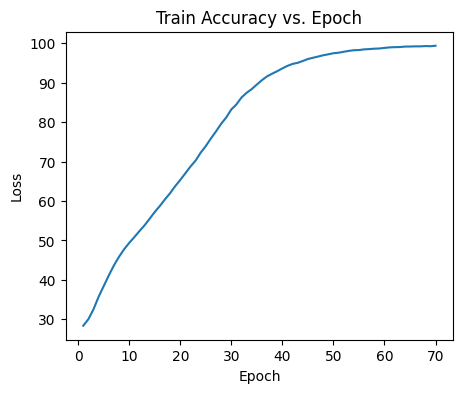

In [64]:
import matplotlib.pyplot as plt
import numpy as np

def plot_predictions(epochs,losses,predictions=None):
  plt.figure(figsize=(5,4))
  plt.plot(epochs, losses)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Train Accuracy vs. Epoch')
  plt.show()
plot_predictions(epoch_count,train_acc)

In [65]:
characters = string.ascii_uppercase + string.digits
idx_to_char = {idx: char for idx, char in enumerate(characters)}
def to_text(arr):
    ans=''
    for c in arr:
        ans=ans+idx_to_char[c.item()]
    return ans


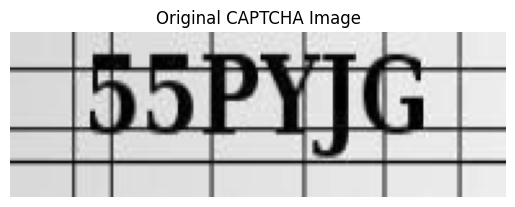

tensor([[31, 31, 15, 24,  9,  6]], device='cuda:0')
True : 55PYJG
Pred : 55PYJG


In [66]:
from itertools import groupby

characters = string.ascii_uppercase + string.digits
idx_to_char = {idx: char for idx, char in enumerate(characters)}
def to_text(arr):
    ans=''
    for c in arr:
        ans=ans+idx_to_char[c.item()]
    return ans

import matplotlib.pyplot as plt

model.eval()  # Set to eval mode

with torch.no_grad():
    for X, y in train_loader:
        # Select one sample
        X_single = X[0]
        y_single = y[0]

        # Show original image
        plt.imshow(X_single.numpy().squeeze(), cmap='gray')
        plt.title("Original CAPTCHA Image")
        plt.axis("off")
        plt.show()

        # Model output
        input_tensor = X_single.unsqueeze(0).to(device)
        output = model(input_tensor)  # [W, B, VOCAB_SIZE]
        output = F.log_softmax(output, dim=2)
        pred = output.argmax(dim=2).squeeze(1)  # [W]
        print(pred)
        # Decode prediction
        pred_text=''
        for i in pred:
            pred_text+= to_text(i)
        true_text = ''.join([idx_to_char[c.item()] for c in y_single if c.item() != -1])

        print(f"True : {true_text}")
        print(f"Pred : {pred_text}")
        break

In [67]:
# 1. Instantiate the model
loaded_model = CaptchaCrackNet() 

# 2. Load the state dictionary
#Replace 'final.pth' or '10.pth' with your actual saved file name
state_dict = torch.load('final.pth', map_location=torch.device('cpu')) # you may need map_location=torch.device('cpu')

# 3. Load the state dictionary into the model
loaded_model.load_state_dict(state_dict) 

# Set the model to evaluation mode
loaded_model.eval()

/tmp/ipykernel_31/2187190862.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('final.pth', map_location=torch.device('cpu')) # you may need map_lo

CaptchaCrackNet(
  (affn): AFFN()
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 48, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(48, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (crnn): CRNN(
    (conv1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, d